<a href="https://colab.research.google.com/github/biglool/Hologram_Cell_detection/blob/main/notebooks/test%20rcnn/R_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import keras
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tq

from tensorflow.keras.utils import Sequence


from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import tensorflow as tf
from PIL import Image
import zipfile


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Curro/Hologrames/Datos_sinteticos/Holo_subdiv/sub/1000_muestras_completas_small_count'

/content/gdrive/MyDrive/Curro/Hologrames/Datos_sinteticos/Holo_subdiv/sub/1000_muestras_completas_small_count


In [ ]:
import pickle

class DataGenerator(Sequence):
    def __init__(self, data_folder, ground_truth_folder, batch_size, img_shape, shuffle=True,max_examples=0):
        self.data_folder = data_folder
        self.ground_truth_folder = ground_truth_folder
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.data_files = sorted([f for f in os.listdir(data_folder) ])
        self.ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) ])
        self.indexes = np.arange(len(self.data_files))
        self.max_examples=max_examples
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        if  self.max_examples ==0:
          num_exemp=len(self.data_files)
        else:
          num_exemp=self.max_examples
        return int(np.floor(num_exemp / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch_data_files = [self.data_files[k] for k in batch_indexes]
        batch_ground_truth_files = [self.ground_truth_files[k] for k in batch_indexes]

        # Generate data
        X, y = self.__data_generation(batch_data_files, batch_ground_truth_files)

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def scale_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = 2 * (array - min_val) / (max_val - min_val) - 1
        return scaled_array

    def __data_generation(self, batch_data_files, batch_ground_truth_files):
        # Initialization
        X = np.empty((self.batch_size, *self.img_shape), dtype='float32')
        y = np.empty((self.batch_size, 32, 4), dtype='float32') # Ensure it matches num_rois and 4 coordinates

        # Generate data
        for i, (data_file, gt_file) in enumerate(zip(batch_data_files, batch_ground_truth_files)):
            # Load data
            data_array = np.loadtxt(os.path.join(self.data_folder, data_file))
            data_array = self.scale_array(data_array)
            data_array = data_array.reshape(self.img_shape)

            # Load ground truth from pickle and process it
            with open(os.path.join(self.ground_truth_folder, gt_file), 'rb') as f:
                ground_truth_list = pickle.load(f)
                # Remove the last element (r2) from each sub-array
                processed_ground_truth =  []
                for obj in ground_truth_list:
                    rad=obj[3]
                    processed_ground_truth.append([obj[0]-rad, obj[1]-rad, obj[0]+rad, obj[1]+rad])
                # Ensure it fits into (32, 4)
                if len(processed_ground_truth) < 32:
                    padding = np.zeros((32 - len(processed_ground_truth), 4), dtype='float32')
                    processed_ground_truth = np.vstack((processed_ground_truth, padding))
                else:
                    processed_ground_truth = np.array(processed_ground_truth)[:32]

            # Store in arrays
            X[i,] = data_array
            y[i,] = processed_ground_truth

        return X, y


data_folder = 'mascaras' #afegir  destino
ground_truth_folder = 'parametros' #afegir  destino
img_shape = (256,256,1)
batch_size=16
#(2662,2128,1)


# Create data generators for training, validation, and test sets
train_gen = DataGenerator(data_folder+"/train/", ground_truth_folder+"/train/", batch_size, img_shape, shuffle=True)
val_gen = DataGenerator(data_folder+"/val/", ground_truth_folder+"/val/", batch_size, img_shape, shuffle=False)
test_gen = DataGenerator(data_folder+"/test/", ground_truth_folder+"/test/", batch_size, img_shape, shuffle=False)

[[137.   129.75 147.5  140.25]
 [185.25 151.75 195.25 161.75]
 [ 89.5   76.   100.    86.5 ]
 [110.25 126.5  120.25 136.5 ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]]


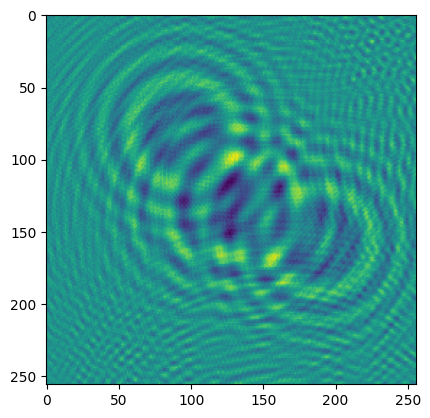

In [ ]:
x,y = test_gen.__getitem__(1)

plt.imshow(x[0])

print(y[0])


In [ ]:
def generate_all_anchors(image_size, grid_size, base_size, ratios, scales):
    """
    Generate all anchors for an entire grid on an image.
    Args:
    - image_size: (width, height) of the image
    - grid_size: size of the grid (n_tiles_x, n_tiles_y)
    - base_size: size of each tile (width and height)
    - ratios: list of aspect ratios
    - scales: list of scales
    Returns:
    - all_anchors: dictionary with tile indices as keys and list of anchors as values
    """
    all_anchors = {}
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            center_x = i * base_size + base_size / 2
            center_y = j * base_size + base_size / 2
            anchors = generate_anchors_for_tile((center_x, center_y), base_size, ratios, scales, image_size)
            all_anchors[(i, j)] = anchors
    return all_anchors

def generate_anchors_for_tile(center, base_size, ratios, scales, image_size):
    """
    Generate anchor boxes centered on a specific point in the tile with boundary checks.
    """
    anchors = []
    for scale in scales:
        for ratio in ratios:
            w = base_size * scale * np.sqrt(ratio)
            h = base_size * scale / np.sqrt(ratio)
            x1 = center[0] - w / 2
            y1 = center[1] - h / 2
            x2 = center[0] + w / 2
            y2 = center[1] + h / 2
            x1, x2 = max(0, x1), min(image_size[0], x2)
            y1, y2 = max(0, y1), min(image_size[1], y2)
            anchors.append([x1, y1, x2, y2])
    return anchors

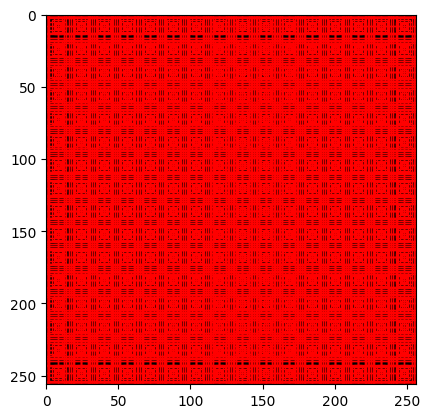

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_anchors_on_image(image_size, all_anchors):
    """
    Plot all anchors on an image.
    """
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal')
    ax.imshow(np.zeros(image_size), extent=(0, image_size[0], 0, image_size[1]), cmap='gray')

    for _, anchors in all_anchors.items():
        for (x1, y1, x2, y2) in anchors:
            ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none'))

    plt.gca().invert_yaxis()  # Invert Y axis to match image coordinate system
    plt.show()

# Configuration
image_size = (256, 256)
grid_size = (16, 16)
tile_size = 16
ratios = [0.5, 1, 2]  # Aspect ratios
scales = [0.25, 0.5, 1, 2]  # Scales based on the constraint

# Generate all anchors
all_anchors = generate_all_anchors(image_size, grid_size, tile_size, ratios, scales)

# Plot the anchors
plot_anchors_on_image(image_size, all_anchors)

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, TimeDistributed, Dense, Flatten, Dropout,  MaxPooling2D
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.utils import Sequence
from keras import initializers, regularizers
import numpy as np
import os
import pickle

def get_backbone(input_tensor):
    inputs = input_tensor

    dropout = 0.3
    L2 = 0.1
    initializer = initializers.HeNormal()

    # Encoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(L2),
                      kernel_initializer=initializer)(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(L2),
                      kernel_initializer=initializer)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(L2),
                      kernel_initializer=initializer)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(L2),
                      kernel_initializer=initializer)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout)(x)

    # Bottleneck
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(L2),
                      kernel_initializer=initializer)(x)

    return x

def rpn_layer(base_layers, num_anchors):
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(base_layers)
    rpn_class = Conv2D(num_anchors, (1, 1), activation='sigmoid')(x)
    rpn_bbox = Conv2D(num_anchors * 4, (1, 1), activation='linear')(x)
    return [rpn_class, rpn_bbox]

def select_rois(rpn_class, rpn_bbox, num_rois=32, img_dims=(None, None)):
    scores = tf.reshape(rpn_class, [-1])
    bboxes = tf.reshape(rpn_bbox, [-1, 4])
    selected_indices, valid_outputs = tf.image.non_max_suppression_padded(
        boxes=bboxes,
        scores=scores,
        max_output_size=num_rois,
        iou_threshold=0.3,
        score_threshold=0.3,
        pad_to_max_output_size=True
    )
    selected_indices = tf.cast(selected_indices[:valid_outputs], dtype=tf.int32)
    selected_boxes = tf.gather(bboxes, selected_indices)
    selected_boxes = tf.expand_dims(selected_boxes, axis=0)

    #print(f"Selected ROIs shape: {selected_boxes.shape}")
    #print(f"Number of valid ROIs: {tf.shape(selected_boxes)[1]}")

    return selected_boxes

class RoiPoolingConv(tf.keras.layers.Layer):
    def __init__(self, pool_size, num_rois, **kwargs):
        self.pool_size = pool_size
        self.num_rois = num_rois
        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def call(self, inputs):
        assert(len(inputs) == 2)
        feature_map = inputs[0]
        rois = inputs[1]
        input_shape = tf.shape(feature_map)

        def process_roi(roi):
            x = roi[0]
            y = roi[1]
            w = roi[2]
            h = roi[3]
            x1 = tf.cast(x, 'int32')
            y1 = tf.cast(y, 'int32')
            x2 = tf.cast(x + w, 'int32')
            y2 = tf.cast(y + h, 'int32')

            if tf.less_equal(x2, x1) or tf.less_equal(y2, y1):
                return tf.zeros((self.pool_size, self.pool_size, input_shape[3]), dtype=tf.float32)

            return tf.image.resize(feature_map[:, y1:y2, x1:x2, :], (self.pool_size, self.pool_size))[0]

        outputs = tf.map_fn(process_roi, rois[0], dtype=tf.float32)
        final_output = tf.reshape(outputs, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        return final_output

    def compute_output_shape(self, input_shape):
        return (None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels)


def detection_network(pooled_regions):
    x = TimeDistributed(Flatten())(pooled_regions)
    x = TimeDistributed(Dense(512, activation='relu'))(x)
    coords = TimeDistributed(Dense(4, activation='linear'))(x)
    return coords

input_img = Input(shape=(256, 256, 1))
input_rois = Input(shape=(32, 4))

backbone = get_backbone(input_img)
rpn_class, rpn_bbox = rpn_layer(backbone, num_anchors=9)
selected_rois = select_rois(rpn_class, rpn_bbox)
roi_pooled = RoiPoolingConv(7, num_rois=32)([backbone, selected_rois])
tf.stop_gradient(selected_rois)
detections = detection_network(roi_pooled)

model = Model(inputs=[input_img], outputs=detections)
model.compile(optimizer=Adam(1e-4), loss='mean_squared_error')




# Training the model
#model.fit(train_gen, validation_data=val_gen, epochs=10)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Instructions for updating:
Use fn_output_signature instead


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          80        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 8)          0         ['max_pooling2d[0][0]']   

In [ ]:

ruta_model="Test_frcnn.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ruta_model, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Train the model, doing validation at the end of each epoch.
epochs = 200
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1,

)


Epoch 1/200


InvalidArgumentError: Graph execution error:

Detected at node model/roi_pooling_conv/map/while/cond_1/resize/ResizeBilinear defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-6-8119f69b15cf>", line 9, in <cell line: 9>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "<ipython-input-5-5f53d9de50ce>", line 107, in call

  File "<ipython-input-5-5f53d9de50ce>", line 102, in process_roi

  File "<ipython-input-5-5f53d9de50ce>", line 105, in process_roi

input image must be of non-zero size
	 [[{{node model/roi_pooling_conv/map/while/cond_1/resize/ResizeBilinear}}]] [Op:__inference_train_function_4414]

Basica

In [ ]:
import pickle

class DataGenerator(Sequence):
    def __init__(self, data_folder, ground_truth_folder, batch_size, img_shape, shuffle=True,max_examples=0):
        self.data_folder = data_folder
        self.ground_truth_folder = ground_truth_folder
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.data_files = sorted([f for f in os.listdir(data_folder) ])
        self.ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) ])
        self.indexes = np.arange(len(self.data_files))
        self.max_examples=max_examples
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        if  self.max_examples ==0:
          num_exemp=len(self.data_files)
        else:
          num_exemp=self.max_examples
        return int(np.floor(num_exemp / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch_data_files = [self.data_files[k] for k in batch_indexes]
        batch_ground_truth_files = [self.ground_truth_files[k] for k in batch_indexes]

        # Generate data
        X, y = self.__data_generation(batch_data_files, batch_ground_truth_files)

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def scale_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = 2 * (array - min_val) / (max_val - min_val) - 1
        return scaled_array

    def __data_generation(self, batch_data_files, batch_ground_truth_files):
        # Initialization
        X = np.empty((self.batch_size, *self.img_shape), dtype='float32')
        y = np.empty((self.batch_size, 32, 5), dtype='float32') # Ensure it matches num_rois and 4 coordinates

        # Generate data
        for i, (data_file, gt_file) in enumerate(zip(batch_data_files, batch_ground_truth_files)):
            # Load data
            data_array = np.loadtxt(os.path.join(self.data_folder, data_file))
            data_array = self.scale_array(data_array)
            data_array = data_array.reshape(self.img_shape)

            # Load ground truth from pickle and process it
            with open(os.path.join(self.ground_truth_folder, gt_file), 'rb') as f:
                ground_truth_list = pickle.load(f)
                # Remove the last element (r2) from each sub-array
                processed_ground_truth =  []
                for obj in ground_truth_list:
                    rad=obj[3]
                    processed_ground_truth.append([obj[0]-rad, obj[0]+rad, obj[1]-rad, obj[1]+rad,1])

                # Ensure it fits into (32, 4)
                if len(processed_ground_truth) < 32:
                    padding = np.zeros((32 - len(processed_ground_truth), 5), dtype='float32')
                    processed_ground_truth = np.vstack((processed_ground_truth, padding))
                else:
                    processed_ground_truth = np.array(processed_ground_truth)[:32]

            # Store in arrays
            X[i,] = data_array
            y[i,] = processed_ground_truth

        return X, y


data_folder = 'mascaras' #afegir  destino
ground_truth_folder = 'parametros' #afegir  destino
img_shape = (256,256,1)
batch_size=16
#(2662,2128,1)


# Create data generators for training, validation, and test sets
train_gen = DataGenerator(data_folder+"/train/", ground_truth_folder+"/train/", batch_size, img_shape, shuffle=True)
val_gen = DataGenerator(data_folder+"/val/", ground_truth_folder+"/val/", batch_size, img_shape, shuffle=False)
test_gen = DataGenerator(data_folder+"/test/", ground_truth_folder+"/test/", batch_size, img_shape, shuffle=False)

[[137.   129.75 147.5  140.25   1.  ]
 [185.25 151.75 195.25 161.75   1.  ]
 [ 89.5   76.   100.    86.5    1.  ]
 [110.25 126.5  120.25 136.5    1.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.  ]
 [  0.     0

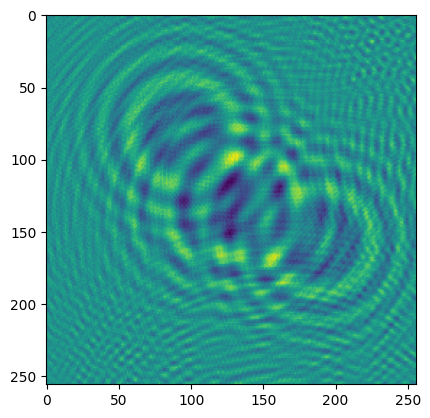

In [ ]:
x,y = test_gen.__getitem__(1)

plt.imshow(x[0])

print(y[0])

In [ ]:
# prompt: load Basic.keras and  frezze the model and use the 5 conv netwoerk as output and add a layer

from keras.models import load_model

model1 = load_model('Basic.keras')
model1.summary()

for layer in model1.layers:
    layer.trainable = False

x = model1.output
x = Dense(5, activation='linear')(x)

model2 = Model(inputs=model1.input, outputs=x)
model2.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
import numpy as np

# Generate dummy data
num_samples = 100
img_height, img_width, img_channels = 256, 256, 1
max_boxes = 32  # Maximum number of bounding boxes per image


# Define the base CNN model
input_tensor = Input(shape=(img_height, img_width, img_channels))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Output layer for bounding box coordinates
bbox_output = Dense(max_boxes * 4, activation='linear')(x)
bbox_output = Reshape((max_boxes, 4))(bbox_output)

# Define the model
model = Model(inputs=input_tensor, outputs=bbox_output)

# Custom loss function to account for mask
def masked_loss(y_true, y_pred):
    mask = y_true[:, :, -1]  # The last element is the mask
    y_true = y_true[:, :, :-1]  # The first four elements are the bounding box coordinates
    mask = tf.expand_dims(mask, axis=-1)  # Expand mask to match bounding box coordinates shape
    mask = tf.tile(mask, [1, 1, 4])  # Tile the mask to match the shape of y_true and y_pred
    loss = tf.reduce_sum(tf.square(y_true - y_pred) * mask) / tf.reduce_sum(mask)
    return loss


# Compile the model
model.compile(optimizer='adam', loss=masked_loss)

# Print model summary for debugging
model.summary()

ruta_model="roi.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ruta_model, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Train the model, doing validation at the end of each epoch.
epochs = 200
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1,

)

# Make predictions
predictions = model.predict(X)
print(predictions)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       7385

KeyboardInterrupt: 

Time distributed

In [ ]:
import pickle

class DataGenerator(Sequence):
    def __init__(self, data_folder, ground_truth_folder, batch_size, img_shape, shuffle=True,max_examples=0):
        self.data_folder = data_folder
        self.ground_truth_folder = ground_truth_folder
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.data_files = sorted([f for f in os.listdir(data_folder) ])
        self.ground_truth_files = sorted([f for f in os.listdir(ground_truth_folder) ])
        self.indexes = np.arange(len(self.data_files))
        self.max_examples=max_examples
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        if  self.max_examples ==0:
          num_exemp=len(self.data_files)
        else:
          num_exemp=self.max_examples
        return int(np.floor(num_exemp / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        batch_data_files = [self.data_files[k] for k in batch_indexes]
        batch_ground_truth_files = [self.ground_truth_files[k] for k in batch_indexes]

        # Generate data
        X, y = self.__data_generation(batch_data_files, batch_ground_truth_files)

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def scale_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        scaled_array = 2 * (array - min_val) / (max_val - min_val) - 1
        return scaled_array

    def __data_generation(self, batch_data_files, batch_ground_truth_files):
        # Initialization
        X = np.empty((self.batch_size, *self.img_shape), dtype='float32')
        y = np.empty((self.batch_size, 32, 4), dtype='float32') # Ensure it matches num_rois and 4 coordinates

        # Generate data
        for i, (data_file, gt_file) in enumerate(zip(batch_data_files, batch_ground_truth_files)):
            # Load data
            data_array = np.loadtxt(os.path.join(self.data_folder, data_file))
            data_array = self.scale_array(data_array)
            data_array = data_array.reshape(self.img_shape)

            # Load ground truth from pickle and process it
            with open(os.path.join(self.ground_truth_folder, gt_file), 'rb') as f:
                ground_truth_list = pickle.load(f)
                # Remove the last element (r2) from each sub-array
                processed_ground_truth =  []
                for obj in ground_truth_list:
                    rad=obj[3]
                    processed_ground_truth.append([obj[0]-rad, obj[0]+rad, obj[1]-rad, obj[1]+rad])

                # Ensure it fits into (32, 4)
               # if len(processed_ground_truth) < 32:
                #    padding = np.zeros((32 - len(processed_ground_truth), 5), dtype='float32')
                 #   processed_ground_truth = np.vstack((processed_ground_truth, padding))
                #else:
                 #   processed_ground_truth = np.array(processed_ground_truth)[:32]

            # Store in arrays
            X[i,] = data_array
            y[i,] = processed_ground_truth

        return X, y


data_folder = 'mascaras' #afegir  destino
ground_truth_folder = 'parametros' #afegir  destino
img_shape = (256,256,1)
batch_size=16
#(2662,2128,1)


# Create data generators for training, validation, and test sets
train_gen = DataGenerator(data_folder+"/train/", ground_truth_folder+"/train/", batch_size, img_shape, shuffle=True)
val_gen = DataGenerator(data_folder+"/val/", ground_truth_folder+"/val/", batch_size, img_shape, shuffle=False)
test_gen = DataGenerator(data_folder+"/test/", ground_truth_folder+"/test/", batch_size, img_shape, shuffle=False)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, TimeDistributed, LSTM
from tensorflow.keras.models import Model
import numpy as np

# Generate dummy data
num_samples = 100
img_height, img_width, img_channels = 256, 256, 1
max_boxes = 32  # Maximum number of bounding boxes per image
X = np.random.rand(num_samples, img_height, img_width, img_channels).astype(np.float32)

# Generate random bounding boxes
y_boxes = np.random.rand(num_samples, max_boxes, 4).astype(np.float32)  # Bounding box coordinates

# Define the base CNN model
input_tensor = Input(shape=(img_height, img_width, img_channels))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Use TimeDistributed to handle variable number of bounding boxes
box_input = Input(shape=(None, 4))  # Variable number of bounding boxes per image
box_lstm = LSTM(64, return_sequences=True)(box_input)
box_output = TimeDistributed(Dense(4, activation='linear'))(box_lstm)

# Define the model
cnn_model = Model(inputs=input_tensor, outputs=x)
box_model = Model(inputs=box_input, outputs=box_output)

# Combine the models
combined_input = Input(shape=(img_height, img_width, img_channels))
cnn_features = cnn_model(combined_input)
cnn_features = Reshape((1, -1))(cnn_features)
combined_output = box_model(cnn_features)

# Define the combined model
model = Model(inputs=combined_input, outputs=combined_output)

# Custom loss function to handle variable number of bounding boxes
def variable_loss(y_true, y_pred):
    loss = tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))
    return loss

# Compile the model
model.compile(optimizer='adam', loss=variable_loss)

# Print model summary for debugging
model.summary()

ruta_model="roi.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ruta_model, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Train the model, doing validation at the end of each epoch.
epochs = 200
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1,

)

# Make predictions
predictions = model.predict(X)
print(predictions)

ValueError: Exception encountered when calling layer "model_1" (type Functional).

Input 0 of layer "lstm" is incompatible with the layer: expected shape=(None, None, 4), found shape=(None, 1, 64)

Call arguments received by layer "model_1" (type Functional):
  • inputs=tf.Tensor(shape=(None, 1, 64), dtype=float32)
  • training=None
  • mask=None

Time dristributed + class

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, TimeDistributed, LSTM
from tensorflow.keras.models import Model
import numpy as np

# Generate dummy data
num_samples = 100
img_height, img_width, img_channels = 256, 256, 1
max_boxes = 32  # Maximum number of bounding boxes per image
num_classes = 3  # Number of object classes (excluding background)

X = np.random.rand(num_samples, img_height, img_width, img_channels).astype(np.float32)

# Generate random bounding boxes and class labels
y_boxes = np.random.rand(num_samples, max_boxes, 4).astype(np.float32)  # Bounding box coordinates
y_classes = np.random.randint(num_classes, size=(num_samples, max_boxes))  # Class labels for bounding boxes
y_classes = tf.keras.utils.to_categorical(y_classes, num_classes=num_classes)  # One-hot encode class labels

# Combine bounding boxes and class labels
y_combined = np.concatenate([y_boxes, y_classes], axis=-1)  # Shape: (num_samples, max_boxes, 4 + num_classes)

# Define the base CNN model
input_tensor = Input(shape=(img_height, img_width, img_channels))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Use TimeDistributed to handle variable number of bounding boxes
box_input = Input(shape=(None, 4 + num_classes))  # Variable number of bounding boxes per image
box_lstm = LSTM(64, return_sequences=True)(box_input)
box_output = TimeDistributed(Dense(4 + num_classes, activation='linear'))(box_lstm)

# Define the model
cnn_model = Model(inputs=input_tensor, outputs=x)
box_model = Model(inputs=box_input, outputs=box_output)

# Combine the models
combined_input = Input(shape=(img_height, img_width, img_channels))
cnn_features = cnn_model(combined_input)
cnn_features = Reshape((1, -1))(cnn_features)
combined_output = box_model(cnn_features)

# Define the combined model
model = Model(inputs=combined_input, outputs=combined_output)

# Custom loss function to handle variable number of bounding boxes and class labels
def custom_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :4]
    class_true = y_true[:, :, 4:]
    bbox_pred = y_pred[:, :, :4]
    class_pred = y_pred[:, :, 4:]

    bbox_loss = tf.reduce_sum(tf.square(bbox_true - bbox_pred)) / tf.reduce_sum(tf.cast(tf.not_equal(bbox_true, 0), tf.float32))
    class_loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(class_true, class_pred)) / tf.reduce_sum(tf.cast(tf.not_equal(class_true, 0), tf.float32))

    return bbox_loss + class_loss

# Compile the model
model.compile(optimizer='adam', loss=custom_loss)

# Print model summary for debugging
model.summary()

# Train the model
model.fit(X, y_combined, epochs=10, batch_size=8)

# Make predictions
predictions = model.predict(X)
print(predictions)

Implementacio complexa frcnn

In [ ]:
!git clone https://github.com/kbardool/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 635, done.
remote: Total 635 (delta 0), reused 0 (delta 0), pack-reused 635
Receiving objects: 100% (635/635), 187.79 KiB | 1.46 MiB/s, done.
Resolving deltas: 100% (433/433), done.
